In [1]:
from pyqcu.torch import qcu
import torch
# lat_x, lat_y, lat_z, lat_t = 16, 16, 8, 8
lat_x, lat_y, lat_z, lat_t = 8, 8, 8, 8
_qcu = qcu(lat_size=[lat_x, lat_y, lat_z, lat_t], dtype_list=[torch.complex128, torch.complex64, torch.complex64, torch.complex32], device_list=[
           torch.device('cpu'), torch.device('cpu'), torch.device('cpu'), torch.device('cpu')], dslash='clover', solver='bistabcg', verbose=False)
_qcu.load()
_qcu.init()

Error: MPI_ERR_COMM: invalid communicator
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
rank 0: Data is loaded from -b.h5 (MPI mode)
rank 0: Data is loaded from -x.h5 (MPI mode)
rank 0: Data is loaded from -x0.h5 (MPI mode)
rank 0: Data is loaded from -U.h5 (MPI mode)
rank 0: Data is loaded from -clover_term.h5 (MPI mode)
self.dof_list:[12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
self.dtype_list:[torch.complex128, torch.complex64, torch.complex64, torch.complex32]
self.device_list:[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
[MPI Rank 0/1] Using cpu:0
self.lat_size_list:[[8, 8, 8, 8], [4, 4, 4, 4], [2, 2, 2, 2]]



Performance Statistics:
Total iterations: 174
Total time: 3.932392 seconds
Average time per iteration: 0.022598 s
Final residual: 6.99e-07

Performance Statistics:
Total time: 3.947925 seconds
Final residual: 6.99e-07

Performance Statistics:
self.solver-bistabcg-Total time: 3.949146 seconds
torch_norm(self.U): 221.7025033768523
torch_norm(self.clover_term): 10.426079724047916
torch_norm(self.b): 221.84345260568398
torch_norm(self.x): 496.1834933250718
multi_norm(self.U): 221.7025033768526
multi_norm(self.clover_term): 10.426079724047906
multi_norm(self.b): 221.84345260568313
multi_norm(self.x): 496.1834933250707
torch_norm(_full_b): 221.84345260568398
torch_norm(_full_x): 496.1834933250718
torch_norm(full_Ax): 221.84345260568335
torch_norm(_full_Ax): 221.84345260568335
torch_norm(full_Ax-_full_b).item()/torch_norm(full_Ax).item(): 3.152643939981282e-09
torch_norm(_full_Ax-_full_b).item()/torch_norm(_full_Ax).item(): 3.152643939683136e-09
torch_norm(full_Ax-_full_Ax).item()/torch_norm

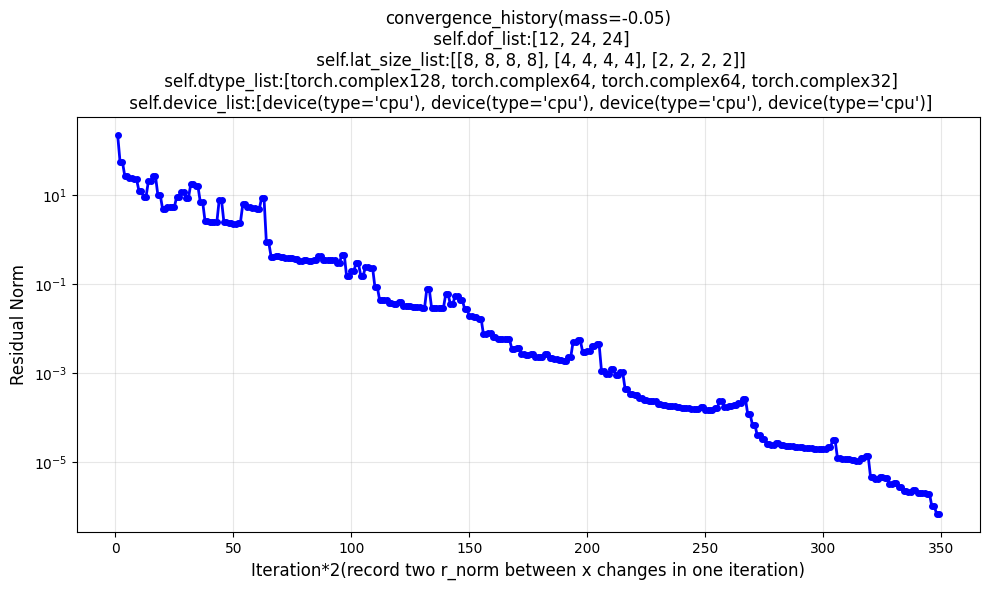

rank 0: Data is saved to -b.h5 (MPI mode)
rank 0: Data is saved to -x.h5 (MPI mode)
rank 0: Data is saved to -x0.h5 (MPI mode)
rank 0: Data is saved to -U.h5 (MPI mode)
rank 0: Data is saved to -clover_term.h5 (MPI mode)


In [2]:
b = _qcu.b.clone()
x = _qcu.solve().clone()
b = b.reshape(shape=[12]+list(b.shape[-4:]))
x = x.reshape(shape=[12]+list(x.shape[-4:]))
_qcu.test()
_qcu.mg.plot(
    save_path=f"test.ascend.{_qcu.solver}.{_qcu.device_list[0].type}-np{_qcu.size}-dev60.png")
_qcu.save()

In [15]:
from pyqcu.torch.define import *
from pyqcu.torch.dslash import *
_ = xxxtzyx2pxxxtzyx(input_array=b)
b_e = _[0]
b_o = _[1]
_ = xxxtzyx2pxxxtzyx(input_array=x)
x_e = _[0]
x_o = _[1]

M_minus_list = _qcu.mg.op_list[0].hopping.M_minus_list
M_plus_list = _qcu.mg.op_list[0].hopping.M_plus_list
M = _qcu.mg.op_list[0].sitting.M

M_e_minus_list = []
M_o_minus_list = []
M_e_plus_list = []
M_o_plus_list = []
_ = xxxtzyx2pxxxtzyx(input_array=M)
M_e = _[0]
M_o = _[1]
for ward in range(4):
    _ = xxxtzyx2pxxxtzyx(input_array=M_minus_list[ward])
    M_e_minus_list.append(_[0])
    M_o_minus_list.append(_[1])
    _ = xxxtzyx2pxxxtzyx(input_array=M_plus_list[ward])
    M_e_plus_list.append(_[0])
    M_o_plus_list.append(_[1])

M_e_minus_x_shift = torch_roll(M_e_minus_list[0], shifts=-1, dims=-1)
M_o_plus_x_shift = torch_roll(M_o_plus_list[0], shifts=1, dims=-1)


def matvec0(src):
    wilson = wilson_mg()
    dest = torch_einsum(
        "EeTZYX, eTZYX->ETZYX", M, src).clone()
    for ward in range(4):
        dest += wilson.give_wilson_minus(ward=ward,
                                         src=src, hopping=M_minus_list[ward])
        dest += wilson.give_wilson_plus(ward=ward,
                                        src=src, hopping=M_plus_list[ward])
    return dest.clone()


def matvec1(src):
    return _qcu.mg.op_list[0].matvec(src)


def matvec2(src):
    wilson = wilson_mg()
    _ = xxxtzyx2pxxxtzyx(input_array=src)
    src_e = _[0]
    src_o = _[1]
    dest_e = torch_einsum(
        "EeTZYX, eTZYX->ETZYX", M_e, src_e).clone()
    dest_o = torch_einsum(
        "EeTZYX, eTZYX->ETZYX", M_o, src_o).clone()

    for ward in range(0, 1):
        dest_o += wilson.give_wilson_minus(ward=ward,
                                           src=src_e, hopping=M_o_minus_list[ward], parity=0)
        dest_o += wilson.give_wilson_plus(ward=ward,
                                          src=src_e, hopping=M_o_plus_list[ward], parity=0)
        dest_e += wilson.give_wilson_plus(ward=ward,
                                          src=src_o, hopping=M_e_plus_list[ward], parity=1)
        dest_e += wilson.give_wilson_minus(ward=ward,
                                           src=src_o, hopping=M_e_minus_list[ward], parity=1)
    for ward in range(1, 4):
        dest_o += wilson.give_wilson_minus(ward=ward,
                                           src=src_e, hopping=M_o_minus_list[ward])
        dest_o += wilson.give_wilson_plus(ward=ward,
                                          src=src_e, hopping=M_o_plus_list[ward])
        dest_e += wilson.give_wilson_plus(ward=ward,
                                          src=src_o, hopping=M_e_plus_list[ward])
        dest_e += wilson.give_wilson_minus(ward=ward,
                                           src=src_o, hopping=M_e_minus_list[ward])

    dest = pxxxtzyx2xxxtzyx(torch.stack([dest_e, dest_o], dim=0))
    return dest.clone()


print(torch.norm(matvec0(x)-matvec1(x))/torch.norm(matvec0(x)))
print(torch.norm(matvec0(x)-matvec2(x))/torch.norm(matvec0(x)))

tensor(2.6862e-16, dtype=torch.float64)
tensor(1.5509e-16, dtype=torch.float64)


In [4]:
M_e_plus_list[0].shape

torch.Size([12, 12, 8, 8, 8, 4])

In [5]:
b_e.shape

torch.Size([12, 8, 8, 8, 4])

In [6]:
M.shape

torch.Size([12, 12, 8, 8, 8, 8])

In [7]:
_qcu.mg.op_list[0].matvec

<bound method op.matvec of <pyqcu.ascend.inverse.op object at 0x7f97b5d46f20>>